# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Análise e visualização de ativos

### Carrega Dados

In [3]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3705, 4)

<Axes: ylabel='Date'>

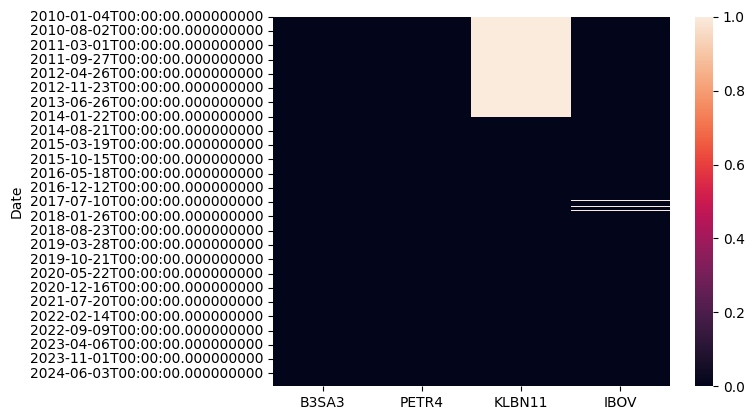

In [4]:
sns.heatmap(acoes_df.isnull())

In [5]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

B3SA3      PETR4     KLBN11      IBOV
Date                                                
2014-01-23  3.250000  15.470000  10.676363   48321.0
2014-01-24  3.233333  15.100000  10.676363   47787.0
2014-01-27  3.300000  15.110000  10.676363   47701.0
2014-01-28  3.280000  15.050000  11.441818   47841.0
2014-01-29  3.170000  14.800000  11.227272   47557.0
...              ...        ...        ...       ...
2024-11-27  9.760000  38.990002  21.290001  127669.0
2024-11-28  9.150000  38.590000  21.709999  124610.0
2024-11-29  9.260000  38.900002  22.209999  125668.0
2024-12-02  9.370000  39.150002  22.370001  125236.0
2024-12-03  9.460000  39.500000  22.650000  126139.0

[2695 rows x 4 columns]

### Visualização dos dados 

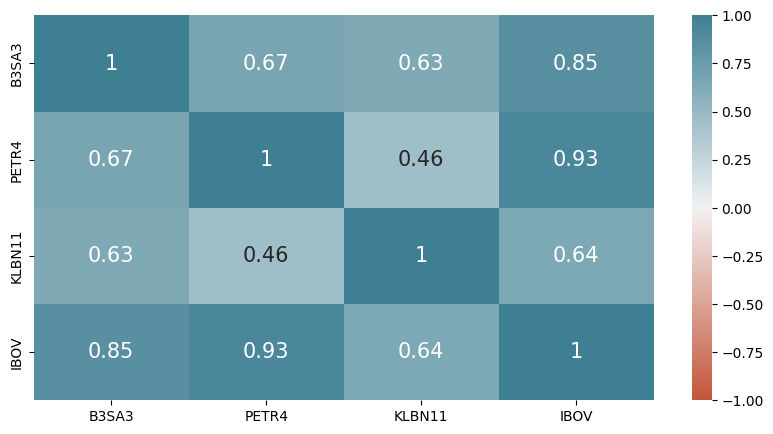

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [7]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [8]:
acoes_df_normalized

B3SA3     PETR4    KLBN11      IBOV
Date                                              
2014-01-23  1.000000  1.000000  1.000000  1.000000
2014-01-24  0.994872  0.976083  1.000000  0.988949
2014-01-27  1.015385  0.976729  1.000000  0.987169
2014-01-28  1.009231  0.972851  1.071696  0.990066
2014-01-29  0.975385  0.956690  1.051601  0.984189
...              ...       ...       ...       ...
2024-11-27  3.003077  2.520362  1.994125  2.642102
2024-11-28  2.815384  2.494505  2.033464  2.578796
2024-11-29  2.849231  2.514544  2.080296  2.600691
2024-12-02  2.883077  2.530705  2.095283  2.591751
2024-12-03  2.910769  2.553329  2.121509  2.610439

[2695 rows x 4 columns]

In [9]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [10]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [11]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [12]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [13]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')



[*********************100%%**********************]  1 of 1 completed


In [14]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [15]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [16]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [17]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


Date       Open       High       Low     Close  Adj Close  \
0    2015-01-02   3.270000   3.270000  3.150000  3.170000   2.187124   
1    2015-01-05   3.143333   3.153333  3.056666  3.083333   2.127330   
2    2015-01-06   3.066666   3.113333  3.033333  3.113333   2.148027   
3    2015-01-07   3.133333   3.283333  3.126666  3.236666   2.233120   
4    2015-01-08   3.296666   3.300000  3.190000  3.193333   2.203223   
...         ...        ...        ...       ...       ...        ...   
2465 2024-11-27  10.130000  10.190000  9.760000  9.760000   9.760000   
2466 2024-11-28   9.770000   9.820000  9.150000  9.150000   9.150000   
2467 2024-11-29   9.200000   9.340000  8.990000  9.260000   9.260000   
2468 2024-12-02   9.200000   9.420000  9.140000  9.370000   9.370000   
2469 2024-12-03   9.400000   9.490000  9.310000  9.460000   9.460000   

        Volume  upper_band_bollinger  lower_band_bollinger       EMA9  ...  \
0     21734100              0.000000              0.000000   3.170000  ...   
1     34790100              0.000000              0.000000   3.121852  ...   
2     49214700              0.000000              0.000000   3.118360  ...   
3     24006600              0.000000              0.000000   3.158437  ...   
4     22967700              0.000000              0.000000   3.168818  ...   
...        ...                   ...                   ...        ...  ...   
2465  57603000             11.072564              9.633436  10.074130  ...   
2466  65340600             11.132040              9.405960   9.889304  ...   
2467  81908200             11.131018              9.254982   9.763443  ...   
2468  78340300             11.114188              9.146813   9.684754  ...   
2469  39449100             11.099821              9.065179   9.639804  ...   

        MA350*2     RSI_14      MACD    Signal  Variation  Classification  \
0      0.000000   0.000000  0.000000  0.000000   0.000000               0   
1      0.000000   0.000000 -0.006914 -0.001383  -2.810824              -1   
2      0.000000   0.000000 -0.009858 -0.003078   0.963597               1   
3      0.000000   0.000000 -0.002215 -0.002905   3.810494               1   
4      0.000000   0.000000  0.000343 -0.002256  -1.356985              -1   
...         ...        ...       ...       ...        ...             ...   
2465  24.426571  25.506131 -0.245532 -0.224980  -4.303279              -1   
2466  24.396800  22.826146 -0.306008 -0.241186  -6.666674              -1   
2467  24.369257  24.199348 -0.341127 -0.261174   1.187912               1   
2468  24.343200  31.349241 -0.355980 -0.280135   1.173956               1   
2469  24.315829  35.772395 -0.356380 -0.295384   0.951376               1   

      weekday  day  month  quarter  
0           5    2      1        1  
1           1    5      1        1  
2           2    6      1        1  
3           3    7      1        1  
4           4    8      1        1  
...       ...  ...    ...      ...  
2465        3   27     11        4  
2466        4   28     11        4  
2467        5   29     11        4  
2468        1    2     12        4  
2469        2    3     12        4  

[2470 rows x 25 columns]

## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [18]:
ticker

'B3SA3.SA'

In [19]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [20]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [21]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
acoes_df = df[['Close']+features_indicators]  
acoes_df_normalized = acoes_df / acoes_df.max().values
acoes_df_normalized.describe()
acoes_df['ds']=df['Date']

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_28968\925237688.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
[feature.split('_') for feature in features_indicators]

[['EMA9'],
 ['EMA20'],
 ['EMA50'],
 ['EMA100'],
 ['EMA200'],
 ['RSI', '14'],
 ['MACD'],
 ['upper', 'band', 'bollinger'],
 ['lower', 'band', 'bollinger']]

In [23]:
def comput_features(data_array, lookback = 1, features_indicators=[]):
    """_summary_

    Args:
        data_array (_type_): transformed dat in scaler 
        lookback (int, optional): _description_. Defaults to 1.
        features_indicators (list, optional): _description_. Defaults to [].

    Returns:
        _type_: _description_
    """
    #df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])


    if  True in ['bollinger' in feature.split('_') for feature in features_indicators]:
        df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df_)
    # Calcula as EMAs de 9 e 20 períodos
    if 'EMA9' in features_indicators:
        df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    if 'EMA20' in features_indicators:   
        df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    if 'EMA50' in features_indicators: 
        df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    if 'EMA100' in features_indicators: 
        df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    if 'EMA200' in features_indicators: 
        df_['EMA200'] = df_['Close'].ewm(span=200).mean()
    if 'MA111' in features_indicators: 
        df_['MA111'] = df_['Close'].rolling(window=111).mean()
    if 'MA350' in features_indicators: 
        df_['MA350'] = df_['Close'].rolling(window=350).mean() 
    if 'RSI_14' in features_indicators: 
        # Calculate RSI (14-period)
        df_['RSI_14'] = calculate_rsi(df, window=14)
    if 'MACD' in features_indicators: 
        # Calculate MACD (12, 26, 9)
        df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)
    
    df_.iloc[:]= np.nan_to_num(df_.values)
    
    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    #for columns in df_.columns:
    #    df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return X_features

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'MA111', 'MA350',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200', 
                     'MA111', 'MA350',
                     'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]
#features_indicators=[]

In [24]:
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [25]:
df_norm

Date       Open       High       Low     Close  Adj Close  \
0    2015-01-02   3.270000   3.270000  3.150000  0.011779   2.187124   
1    2015-01-05   3.143333   3.153333  3.056666  0.007340   2.127330   
2    2015-01-06   3.066666   3.113333  3.033333  0.008877   2.148027   
3    2015-01-07   3.133333   3.283333  3.126666  0.015193   2.233120   
4    2015-01-08   3.296666   3.300000  3.190000  0.012974   2.203223   
...         ...        ...        ...       ...       ...        ...   
2465 2024-11-27  10.130000  10.190000  9.760000  0.349266   9.760000   
2466 2024-11-28   9.770000   9.820000  9.150000  0.318027   9.150000   
2467 2024-11-29   9.200000   9.340000  8.990000  0.323660   9.260000   
2468 2024-12-02   9.200000   9.420000  9.140000  0.329293   9.370000   
2469 2024-12-03   9.400000   9.490000  9.310000  0.333902   9.460000   

        Volume  upper_band_bollinger  lower_band_bollinger       EMA9  ...  \
0     21734100              0.000000              0.000000   3.170000  ...   
1     34790100              0.000000              0.000000   3.121852  ...   
2     49214700              0.000000              0.000000   3.118360  ...   
3     24006600              0.000000              0.000000   3.158437  ...   
4     22967700              0.000000              0.000000   3.168818  ...   
...        ...                   ...                   ...        ...  ...   
2465  57603000             11.072564              9.633436  10.074130  ...   
2466  65340600             11.132040              9.405960   9.889304  ...   
2467  81908200             11.131018              9.254982   9.763443  ...   
2468  78340300             11.114188              9.146813   9.684754  ...   
2469  39449100             11.099821              9.065179   9.639804  ...   

        MA350*2     RSI_14      MACD    Signal  Variation  Classification  \
0      0.000000   0.000000  0.000000  0.000000   0.000000               0   
1      0.000000   0.000000 -0.006914 -0.001383  -2.810824              -1   
2      0.000000   0.000000 -0.009858 -0.003078   0.963597               1   
3      0.000000   0.000000 -0.002215 -0.002905   3.810494               1   
4      0.000000   0.000000  0.000343 -0.002256  -1.356985              -1   
...         ...        ...       ...       ...        ...             ...   
2465  24.426571  25.506131 -0.245532 -0.224980  -4.303279              -1   
2466  24.396800  22.826146 -0.306008 -0.241186  -6.666674              -1   
2467  24.369257  24.199348 -0.341127 -0.261174   1.187912               1   
2468  24.343200  31.349241 -0.355980 -0.280135   1.173956               1   
2469  24.315829  35.772395 -0.356380 -0.295384   0.951376               1   

      weekday  day  month  quarter  
0           5    2      1        1  
1           1    5      1        1  
2           2    6      1        1  
3           3    7      1        1  
4           4    8      1        1  
...       ...  ...    ...      ...  
2465        3   27     11        4  
2466        4   28     11        4  
2467        5   29     11        4  
2468        1    2     12        4  
2469        2    3     12        4  

[2470 rows x 25 columns]

In [26]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        X +=[X_inputs]
        #X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        #X +=[data['Close'].values[win-lookback:win]]
        y += [data[['Close']].values[win:win+pred_days]]
    


    data['Variation'] = ((data['Close'] - data['Close'].shift(+1)) / data['Close'])*100
    #pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y_regression=np.vstack(y)
    return X, y_regression

X, y = windowing(df_norm,features_indicators)
date_time=df_norm['Date'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y regression shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2447, 33)
y regression shape (2447, 1)
Last Date 2024-12-03T00:00:00.000000000


In [27]:
#y=scaler.transform(y)
#for idx in range(len(features_indicators)+ lookback):
#    X[:,idx]=np.squeeze(scaler.transform(X[:,idx].reshape(-1,1)))

In [28]:
features_indicators

['EMA9',
 'EMA20',
 'EMA50',
 'EMA100',
 'EMA200',
 'MA111',
 'MA350',
 'MACD',
 'upper_band_bollinger',
 'lower_band_bollinger']

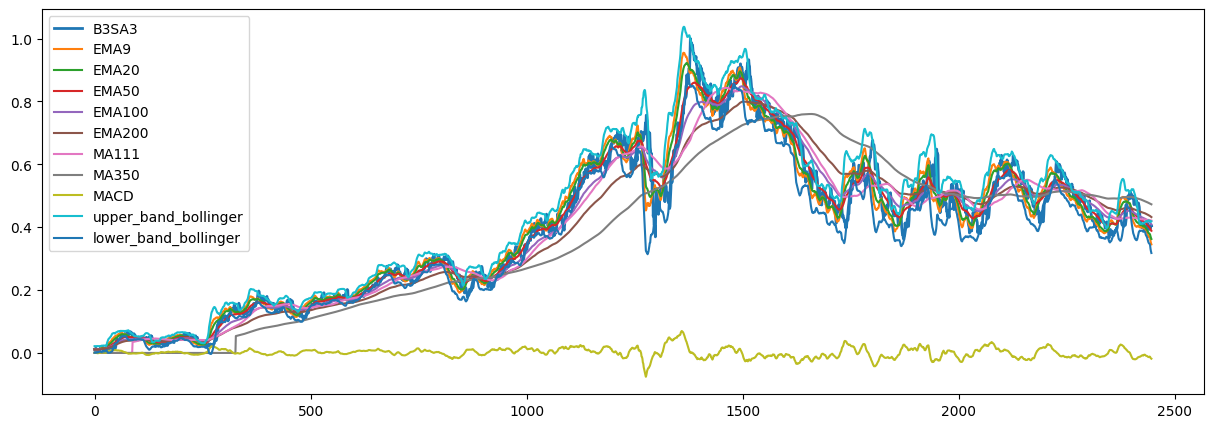

In [29]:
plt.figure(figsize=(15,5))
plt.plot(X[:,0],label=ticker,linewidth=2)
plt.plot(X[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [30]:
# separa os dados em Treino e Teste
def split_data(X : np.array ,y : np.array, date_time : np.datetime64,factor=0.70):
    """Split the data in train validation or test

    Args:
        X (np.array): _description_
        y (np.array): _description_
        date_time (np.datetime64): _description_
        factor (float, optional): _description_. Defaults to 0.70.

    Returns:
        _type_: _description_
    """
    nits=round(len(X)*factor)

    X_train=X[:nits,:]

    nit_test= np.max(X_train.shape) -1
    X_test = X[nit_test:,:]

    y_train =y[:nits]
    y_test =y[nit_test:]

    T_train = date_time[:nits]
    T_test = date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [31]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Neural Networkt aproach

### Used Models

#### CNN_LSTM

In [32]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            384       
                                                                 
 batch_normalization (BatchN  (None, 15, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 32)                143

#### MultiLayer Perceptron

In [33]:
# Model name
model_name = "MLP"

# Input layer
input_data = Input(shape=(X.shape[1],))

# Dense layer 1 with batch normalization
dense1 = Dense(64)(input_data)
bn1 = BatchNormalization()(dense1)
activation1 = Activation('relu')(bn1)

# Dense layer 2 with batch normalization and dropout
dense2 = Dense(128)(activation1)
bn2 = BatchNormalization()(dense2)
activation2 = Activation('relu')(bn2)
dropout2 = Dropout(0.2)(activation2)

# Output layer
output = Dense(1, activation='linear')(dropout2)

# Create the model
model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name = model_name

# Print model summary
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2176      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                               

#### Long Short-Term Memory (LSTM) 

In [34]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                              

#### Long Short-Term Memory (GRU) 

In [35]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                               

#### LSTM with Attention layer

In [36]:
# Define the Attention layer
from keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom", name="Attention_")
class Attention_(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention_, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [37]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention_(64)(X)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 33, 64)            16896     
                                                                 
 batch_normalization_6 (Batc  (None, 33, 64)           256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 33, 64)            0         
                                                                 
 dropout_4 (Dropout)         (None, 33, 64)            0         
                                                                 
 attention_ (Attention_)     (None, 64)                4225      
                                                           

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [38]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [39]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [40]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200
33/46 [====================>.........] - ETA: 0s - loss: 1.5001 - NRMSE: 0.1711 
Epoch 1: val_loss improved from inf to 0.05500, saving model to models\model_MLP_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 10s 109ms/step - loss: 1.1060 - NRMSE: 0.3331 - val_loss: 0.0550 - val_NRMSE: 0.7711 - lr: 0.0500
Epoch 2/200
34/46 [=====================>........] - ETA: 0s - loss: 0.0312 - NRMSE: 0.8292
Epoch 2: val_loss improved from 0.05500 to 0.03839, saving model to models\model_MLP_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 4s 84ms/step - loss: 0.0281 - NRMSE: 0.8390 - val_loss: 0.0384 - val_NRMSE: 0.8167 - lr: 0.0500
Epoch 3/200
46/46 [==============================] - ETA: 0s - loss: 0.0123 - NRMSE: 0.8937
Epoch 3: val_loss improved from 0.03839 to 0.01642, saving model to models\model_MLP_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 3s 72ms/step - loss: 0.0123 - NRMSE: 0.8937 - val_loss: 0.0164 - val_NRMSE: 0.8790 - lr: 0.0500
Epoch 4/200
36/46 [======================>.......] - ETA: 0s - loss: 0.0101 - NRMSE: 0.9045
Epoch 4: val_loss improved from 0.01642 to 0.00607, saving model to models\model_MLP_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 4s 84ms/step - loss: 0.0104 - NRMSE: 0.9030 - val_loss: 0.0061 - val_NRMSE: 0.9296 - lr: 0.0500
Epoch 5/200
43/46 [===========================>..] - ETA: 0s - loss: 0.0072 - NRMSE: 0.9195
Epoch 5: val_loss improved from 0.00607 to 0.00263, saving model to models\model_MLP_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 4s 89ms/step - loss: 0.0070 - NRMSE: 0.9213 - val_loss: 0.0026 - val_NRMSE: 0.9526 - lr: 0.0500
Epoch 6/200
34/46 [=====================>........] - ETA: 0s - loss: 0.0062 - NRMSE: 0.9246
Epoch 6: val_loss did not improve from 0.00263
46/46 [==============================] - 0s 6ms/step - loss: 0.0060 - NRMSE: 0.9257 - val_loss: 0.0077 - val_NRMSE: 0.9229 - lr: 0.0500
Epoch 7/200
36/46 [======================>.......] - ETA: 0s - loss: 0.0052 - NRMSE: 0.9296
Epoch 7: val_loss did not improve from 0.00263
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - NRMSE: 0.9286 - val_loss: 0.0035 - val_NRMSE: 0.9447 - lr: 0.0500
Epoch 8/200
36/46 [======================>.......] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9317
Epoch 8: val_loss did not improve from 0.00263
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - NRMSE: 0.9325 - val_loss: 0.0168 - val_NRMSE: 0.8841 - lr: 0.0500
Epoch 9/200
36/46 [===================

INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 3s 68ms/step - loss: 0.0044 - NRMSE: 0.9364 - val_loss: 0.0013 - val_NRMSE: 0.9658 - lr: 0.0500
Epoch 11/200
33/46 [====================>.........] - ETA: 0s - loss: 0.0041 - NRMSE: 0.9397
Epoch 11: val_loss did not improve from 0.00126
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - NRMSE: 0.9394 - val_loss: 0.0189 - val_NRMSE: 0.8782 - lr: 0.0500
Epoch 12/200
34/46 [=====================>........] - ETA: 0s - loss: 0.0053 - NRMSE: 0.9312
Epoch 12: val_loss improved from 0.00126 to 0.00103, saving model to models\model_MLP_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 3s 72ms/step - loss: 0.0049 - NRMSE: 0.9337 - val_loss: 0.0010 - val_NRMSE: 0.9692 - lr: 0.0500
Epoch 13/200
33/46 [====================>.........] - ETA: 0s - loss: 0.0061 - NRMSE: 0.9283
Epoch 13: val_loss did not improve from 0.00103
46/46 [==============================] - 0s 6ms/step - loss: 0.0068 - NRMSE: 0.9236 - val_loss: 0.0198 - val_NRMSE: 0.8703 - lr: 0.0500
Epoch 14/200
35/46 [=====================>........] - ETA: 0s - loss: 0.0049 - NRMSE: 0.9341
Epoch 14: val_loss did not improve from 0.00103
46/46 [==============================] - 0s 6ms/step - loss: 0.0051 - NRMSE: 0.9325 - val_loss: 0.0042 - val_NRMSE: 0.9437 - lr: 0.0500
Epoch 15/200
35/46 [=====================>........] - ETA: 0s - loss: 0.0043 - NRMSE: 0.9387
Epoch 15: val_loss did not improve from 0.00103
46/46 [==============================] - 0s 6ms/step - loss: 0.0044 - NRMSE: 0.9379 - val_loss: 0.0011 - val_NRMSE: 0.9680 - lr: 0.0500
Epoch 16/200
36/46 [============

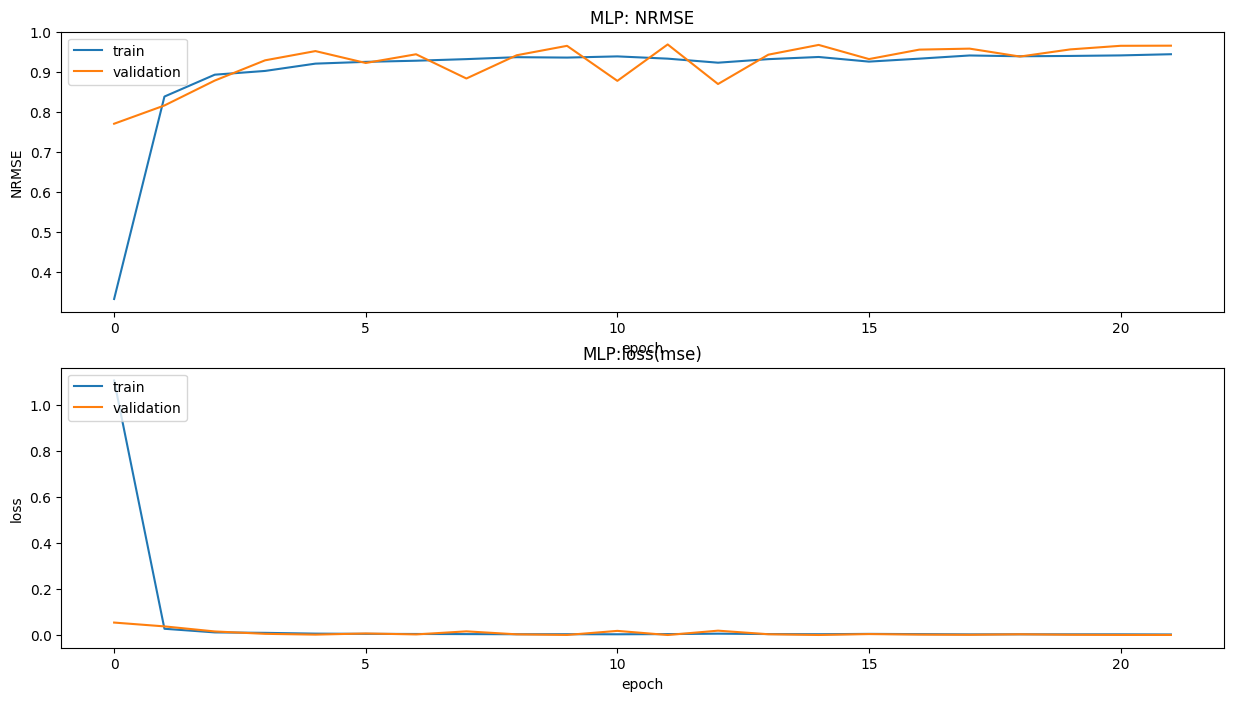

Training model : models/model_GRU_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
44/46 [===========================>..] - ETA: 0s - loss: 0.2026 - NRMSE: 0.6725
Epoch 1: val_loss improved from inf to 0.24951, saving model to models\model_GRU_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 14s 196ms/step - loss: 0.1965 - NRMSE: 0.6806 - val_loss: 0.2495 - val_NRMSE: 0.5191 - lr: 0.0500
Epoch 2/200
46/46 [==============================] - ETA: 0s - loss: 0.0093 - NRMSE: 0.9069
Epoch 2: val_loss improved from 0.24951 to 0.17108, saving model to models\model_GRU_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 9s 202ms/step - loss: 0.0093 - NRMSE: 0.9069 - val_loss: 0.1711 - val_NRMSE: 0.6060 - lr: 0.0500
Epoch 3/200
45/46 [============================>.] - ETA: 0s - loss: 0.0073 - NRMSE: 0.9181
Epoch 3: val_loss improved from 0.17108 to 0.10409, saving model to models\model_GRU_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 8s 181ms/step - loss: 0.0074 - NRMSE: 0.9178 - val_loss: 0.1041 - val_NRMSE: 0.7012 - lr: 0.0500
Epoch 4/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0058 - NRMSE: 0.9267
Epoch 4: val_loss improved from 0.10409 to 0.04940, saving model to models\model_GRU_stock_B3SA3_lookback_23


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


46/46 [==============================] - 15s 342ms/step - loss: 0.0062 - NRMSE: 0.9242 - val_loss: 0.0494 - val_NRMSE: 0.8088 - lr: 0.0500
Epoch 5/200
46/46 [==============================] - ETA: 0s - loss: 0.0055 - NRMSE: 0.9278
Epoch 5: val_loss did not improve from 0.04940
46/46 [==============================] - 1s 32ms/step - loss: 0.0055 - NRMSE: 0.9278 - val_loss: 0.0774 - val_NRMSE: 0.7458 - lr: 0.0500
Epoch 6/200
46/46 [==============================] - ETA: 0s - loss: 0.0079 - NRMSE: 0.9148
Epoch 6: val_loss did not improve from 0.04940
46/46 [==============================] - 2s 40ms/step - loss: 0.0079 - NRMSE: 0.9148 - val_loss: 0.0642 - val_NRMSE: 0.7747 - lr: 0.0500
Epoch 7/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0067 - NRMSE: 0.9228
Epoch 7: val_loss did not improve from 0.04940
46/46 [==============================] - 1s 28ms/step - loss: 0.0067 - NRMSE: 0.9227 - val_loss: 0.0522 - val_NRMSE: 0.7989 - lr: 0.0500
Epoch 8/200
45/46 [==============

In [ ]:
#list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]
list_of_models=[model_LSTM_AT ]
for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

In [ ]:
list_of_models[4].name

'LSTM_AT'

In [ ]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models[:]:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

TypeError: Attention.__init__() got an unexpected keyword argument 'name'

In [ ]:
checkpoint_filepath

'models/model_LSTM_AT_stock_B3SA3_lookback_23'

In [ ]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x1f8d0fe4850>,
 'GRU': <keras.src.engine.functional.Functional at 0x1f8e1b62ce0>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x1f8e1b62440>,
 'LSTM': <keras.src.engine.functional.Functional at 0x1f8a325a110>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x1f8d1150610>}

In [ ]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(df,features_indicators)

for idx in range(len(features_indicators)+lookback):
    X_real[:,idx]=np.squeeze(scaler.transform(X_real[:,idx].reshape(-1,1)))
#X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

#do the smae split data with the original data to compare 
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

11/11 [==============================] - 0s 4ms/step
MLP NN R2: 0.584188267097743
11/11 [==============================] - 1s 15ms/step
GRU NN R2: 0.7247379172046124
11/11 [==============================] - 0s 9ms/step
CNN_LSTM NN R2: 0.5270513493650004
11/11 [==============================] - 1s 26ms/step
LSTM NN R2: 0.6313822906165878
11/11 [==============================] - 1s 22ms/step
LSTM_AT NN R2: 0.6782432252025745


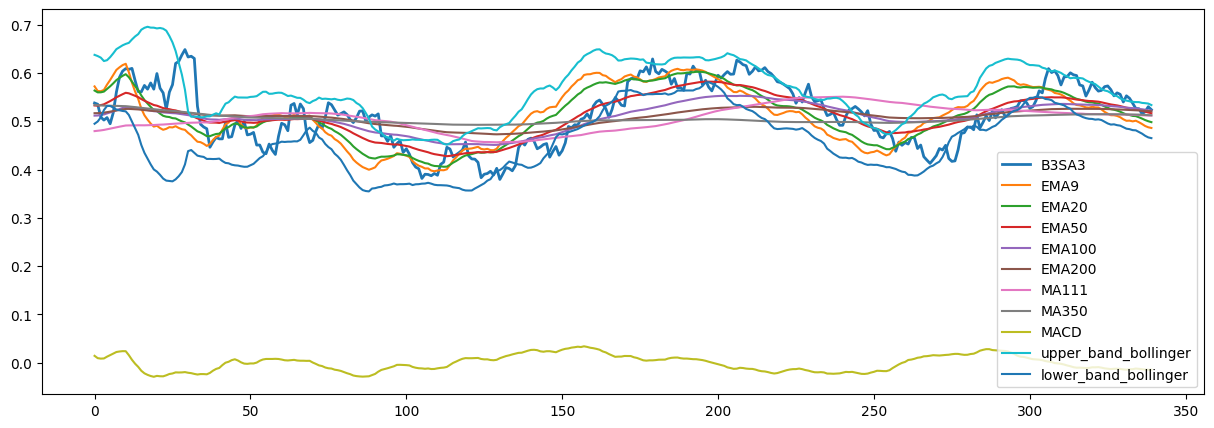

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(X_test[:,0],label=ticker,linewidth=2)
plt.plot(X_test[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [ ]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [ ]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Get new values to future prediction 

In [ ]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-03-08
Estamos Fornecendo dados até o dia : 2024-03-07
O modelo fará previsões até o dia:  2024-03-14


In [ ]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test.copy()
        # normalized data
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1)),lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1))[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    
    for k in range(n_steps):
        # normalzação das features
        #for idx in range(len(features_indicators)+lookback):
        #    X_inputs[-1,idx]=np.squeeze(scaler.transform(X_inputs[-1,idx].reshape(-1,1)))
        

        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)

        
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 43ms/step


In [ ]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

Using ARIMA model


In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [ ]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

Data       pred  Variacao  Subida
334 2024-03-01  12.420000 -3.301126       0
335 2024-03-04  12.300000 -0.975609       0
336 2024-03-05  12.190000 -0.902384       0
337 2024-03-06  12.250000  0.489799       1
338 2024-03-07  12.320000  0.568179       1
339 2024-03-08  13.004989  5.267127       1
340 2024-03-11  13.062728  0.442013       1
341 2024-03-12  13.072406  0.074031       1
342 2024-03-13  13.142721  0.535017       1
343 2024-03-14  13.147493  0.036295       1

In [ ]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

Data       pred  Variacao  Subida
339 2024-03-08  13.004989  5.267127       1

In [ ]:
result=pred_data_df.iloc[-1:,:]
result

Data       pred  Variacao  Subida
343 2024-03-14  13.147493  0.036295       1

In [ ]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-03-14 é de subida, de 0.04% o valor predito é de: 13.15


In [ ]:
comput_features(y_test, lookback, features_indicators).reshape(1,-1)

array([[ 0.51877778,  0.52594748,  0.53721414,  0.52338687,  0.52748383,
         0.50802325,  0.4993172 ,  0.50136568,  0.4993172 ,  0.51212021,
         0.50546269,  0.49726872,  0.48702633,  0.48856268,  0.50238995,
         0.4936839 ,  0.5064869 ,  0.48548998,  0.47934455,  0.47371119,
         0.47678393,  0.48036876,  0.48753846,  0.48633846,  0.49710273,
         0.51547523,  0.52132332,  0.52045901,  0.51180188,  0.        ,
        -0.01341967,  0.52627218,  0.46724105]])

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 58ms/step


array([[12.991828]], dtype=float32)